<h1>1.5. Combinación de imágenes

    reduce el ruido en las imágenes

    puede eliminar artefactos transitorios como rayos cósmicos y pistas de satélite

    puede eliminar estrellas en imágenes planas tomadas en el crepúsculo

<h1>1.5.1 Combinar imagenes promediandolas

In [1]:
import os

import numpy as np

%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import rc

from astropy.visualization import hist
from astropy.stats import mad_std

In [2]:
# Use custom style for larger fonts and figures
plt.style.use('guide.mplstyle')

In [3]:
# Set some default parameters for the plots below
rc('font', size=20)
rc('axes', grid=True)

In [4]:
# Set up the random number generator, allowing a seed to be set from the environment
seed = os.getenv('GUIDE_RANDOM_SEED', None)

if seed is not None:
    seed = int(seed)
    
# This is the generator to use for any image component which changes in each image, e.g. read noise
# or Poisson error
noise_rng = np.random.default_rng(seed)

<h1>1.5.2 Promedio o mediana
   

In [5]:
n_distributions = 100
bias_level = 1000
n_side = 320
bits = noise_rng.normal(size=(n_distributions, n_side**2)) + bias_level
average = np.average(bits, axis=0)
median = np.median(bits, axis=0)

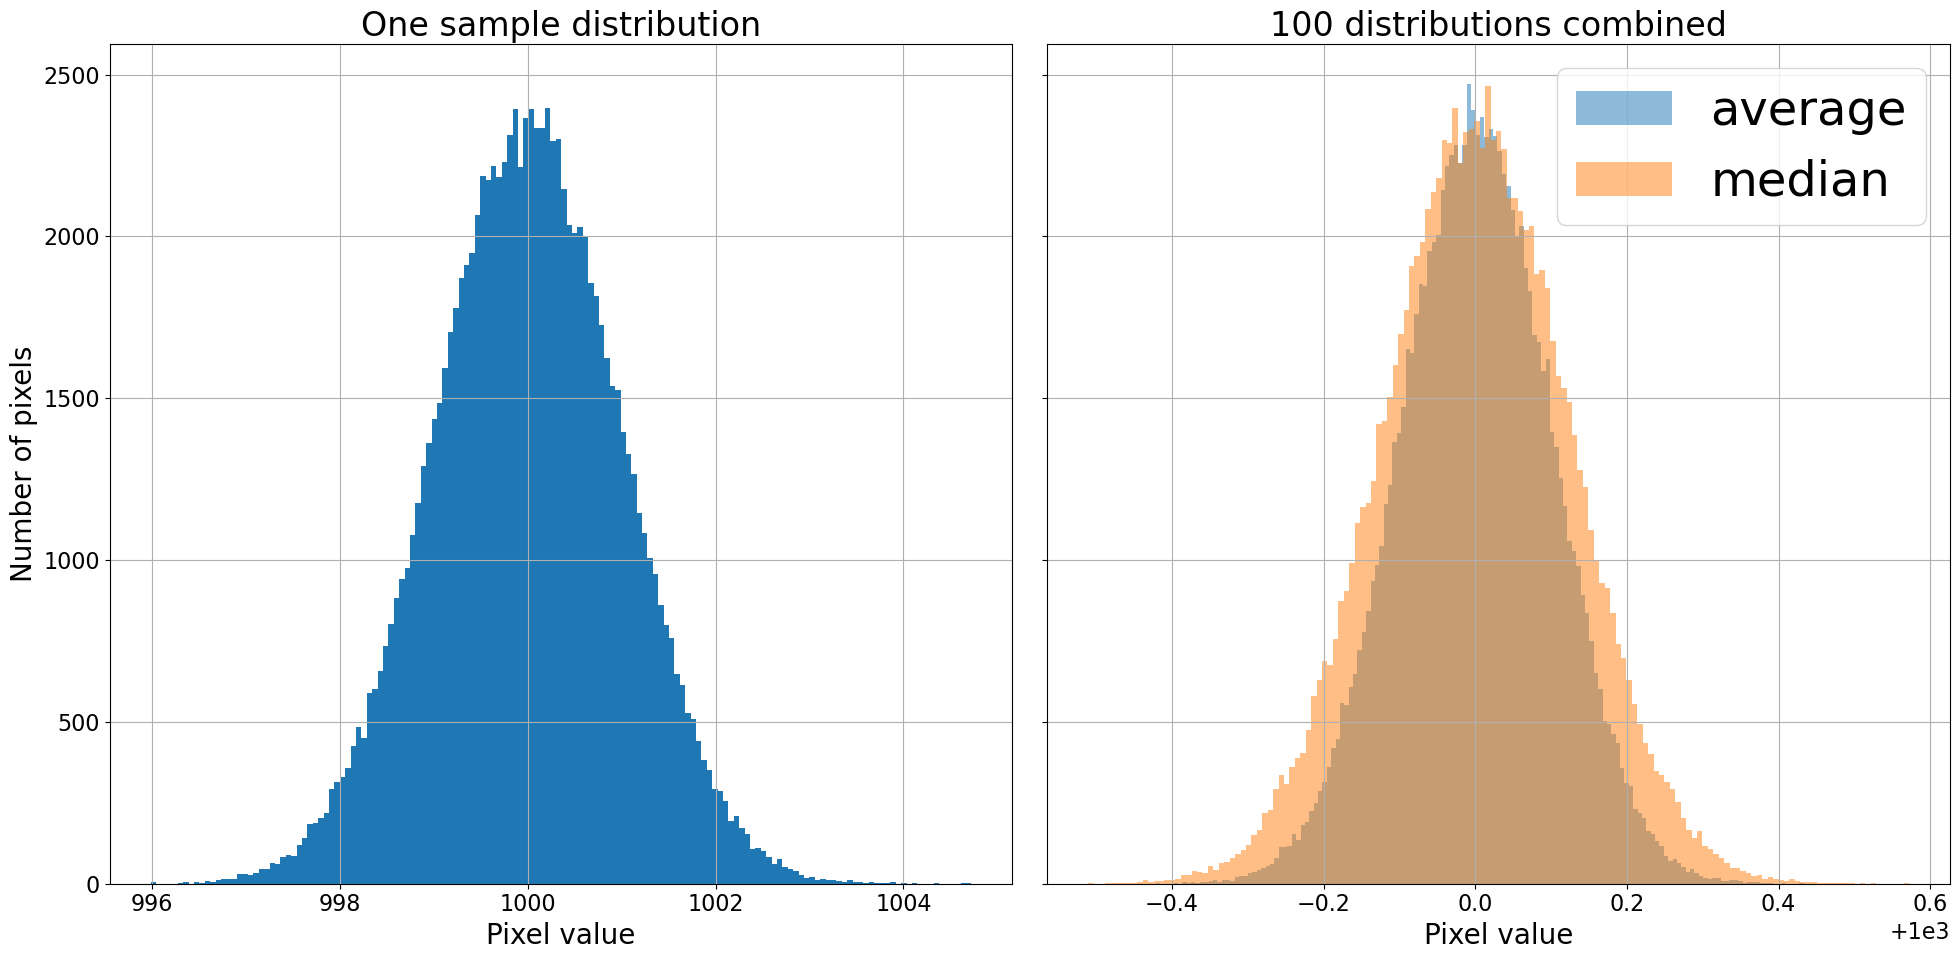

In [6]:
fig, ax = plt.subplots(1, 2, sharey=True, tight_layout=True, figsize=(20, 10))

hist(bits[0, :], bins='freedman', ax=ax[0]);
ax[0].set_title('One sample distribution')
ax[0].set_xlabel('Pixel value')
ax[0].set_ylabel('Number of pixels')

hist(average, bins='freedman', label='average', alpha=0.5, ax=ax[1]);
hist(median, bins='freedman', label='median', alpha=0.5, ax=ax[1]);
ax[1].set_title('{} distributions combined'.format(n_distributions))
ax[1].set_xlabel('Pixel value')
ax[1].legend()

se puede apreciar que ambas imagenes reducieron de manera sustancial el ruido, aun asi se nota que el promedio es ligeramente menos ruidosa que la mediana

<h1>1.5.2.1. imagen visual de la reduccion de ruido

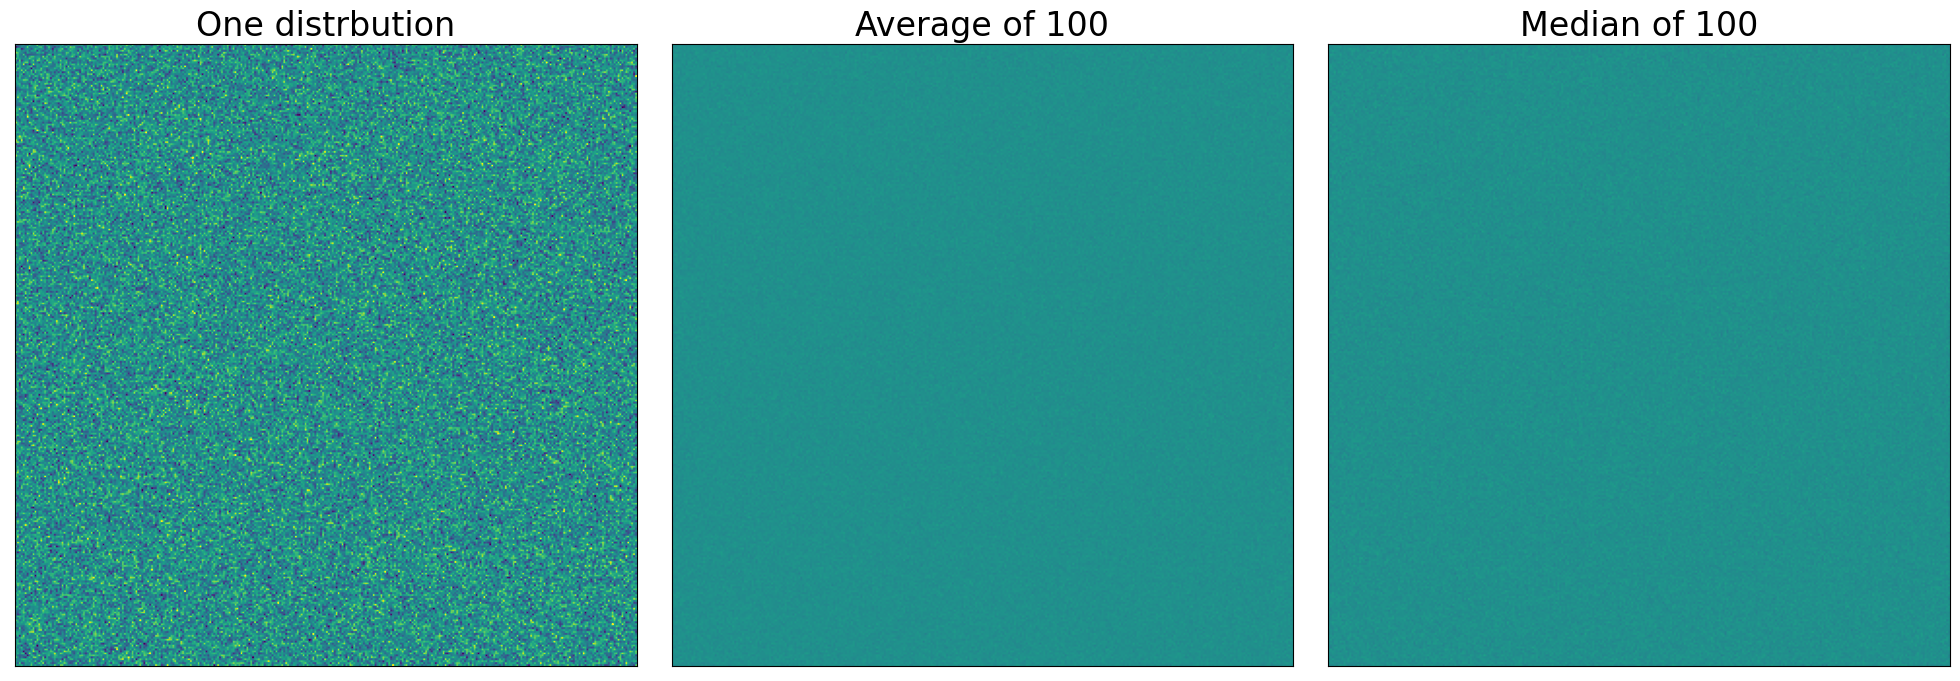

In [7]:
fig, axes = plt.subplots(1, 3, sharey=True, tight_layout=True, figsize=(20, 10))
data_source = [bits[0, :], average, median]
titles = ['One distrbution', 'Average of {n}'.format(n=n_distributions), 'Median of {n}'.format(n=n_distributions)]

for axis, data, title in zip(axes, data_source, titles):
    axis.imshow(data.reshape(n_side, n_side), vmin=bias_level - 3, vmax=bias_level + 3)
    axis.set_xticks([])
    axis.set_yticks([])
    axis.grid(False)
    axis.set_title(title)

se puede apreciar mucho mas facilmente la diferencia enm reducir el ruido mediante una imagen a eliminarlo mediante mediana o media con varias imagenes combinadas

<h1>1.5.3. El efecto de los valores atípicos

Cuando en alguna de las imagenes que se combinan hay valores extremos

In [8]:
bits[0, 10000:10050] = 2 * bias_level

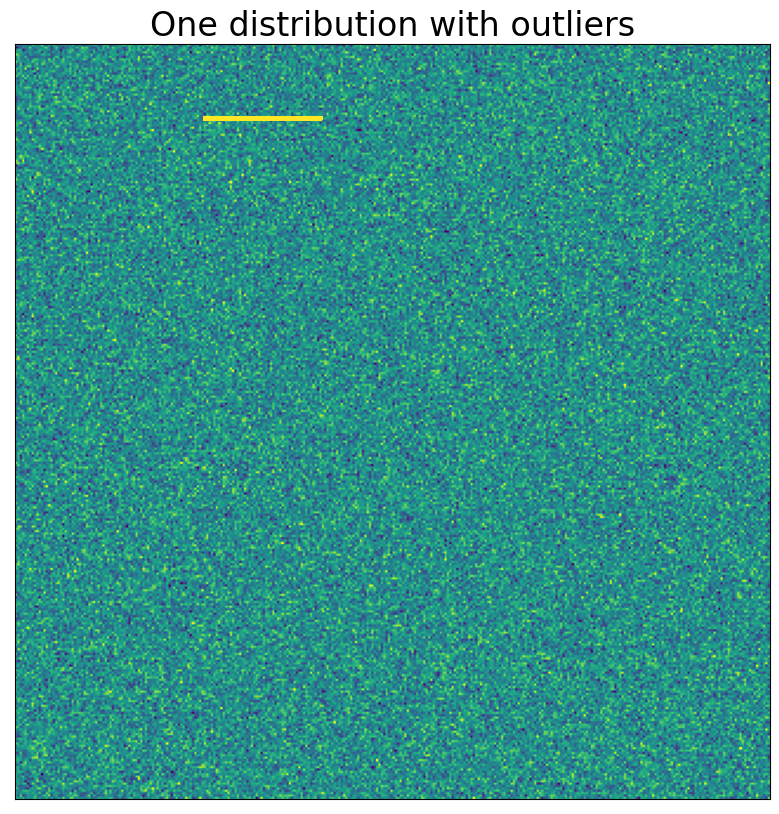

In [9]:
plt.imshow(bits[0, :].reshape(n_side, n_side), vmin=bias_level - 3, vmax=bias_level + 3)
plt.xticks([])
plt.yticks([])
plt.title('One distribution with outliers')
plt.grid(False)

In [10]:
average = np.average(bits, axis=0)
median = np.median(bits, axis=0)

Al combinar ahora las imagenmes se notan claramente las diferencias en el histograma

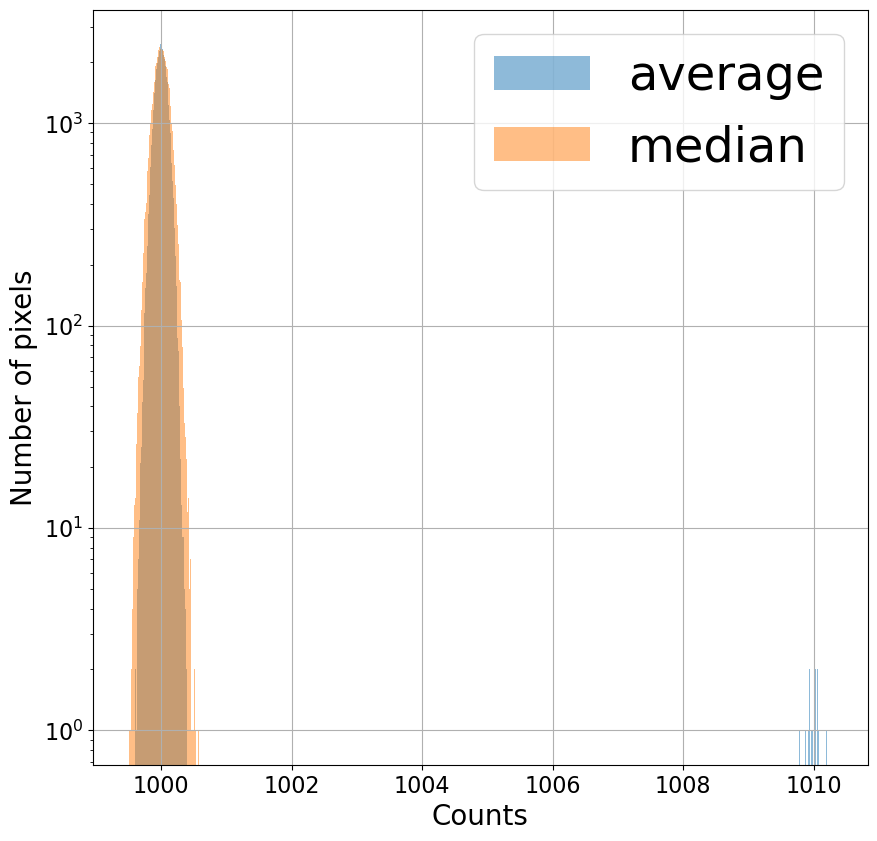

In [12]:
plt.figure(figsize=(10, 10))
hist(average, bins='freedman', alpha=0.5, label='average');
hist(median, bins='freedman', alpha=0.5, label='median');
plt.legend()
plt.xlabel('Counts')
plt.ylabel('Number of pixels')
plt.semilogy();

<h1>1.5.3.1. Diferencia en casos de valores extremos entre combinar por mediana o media

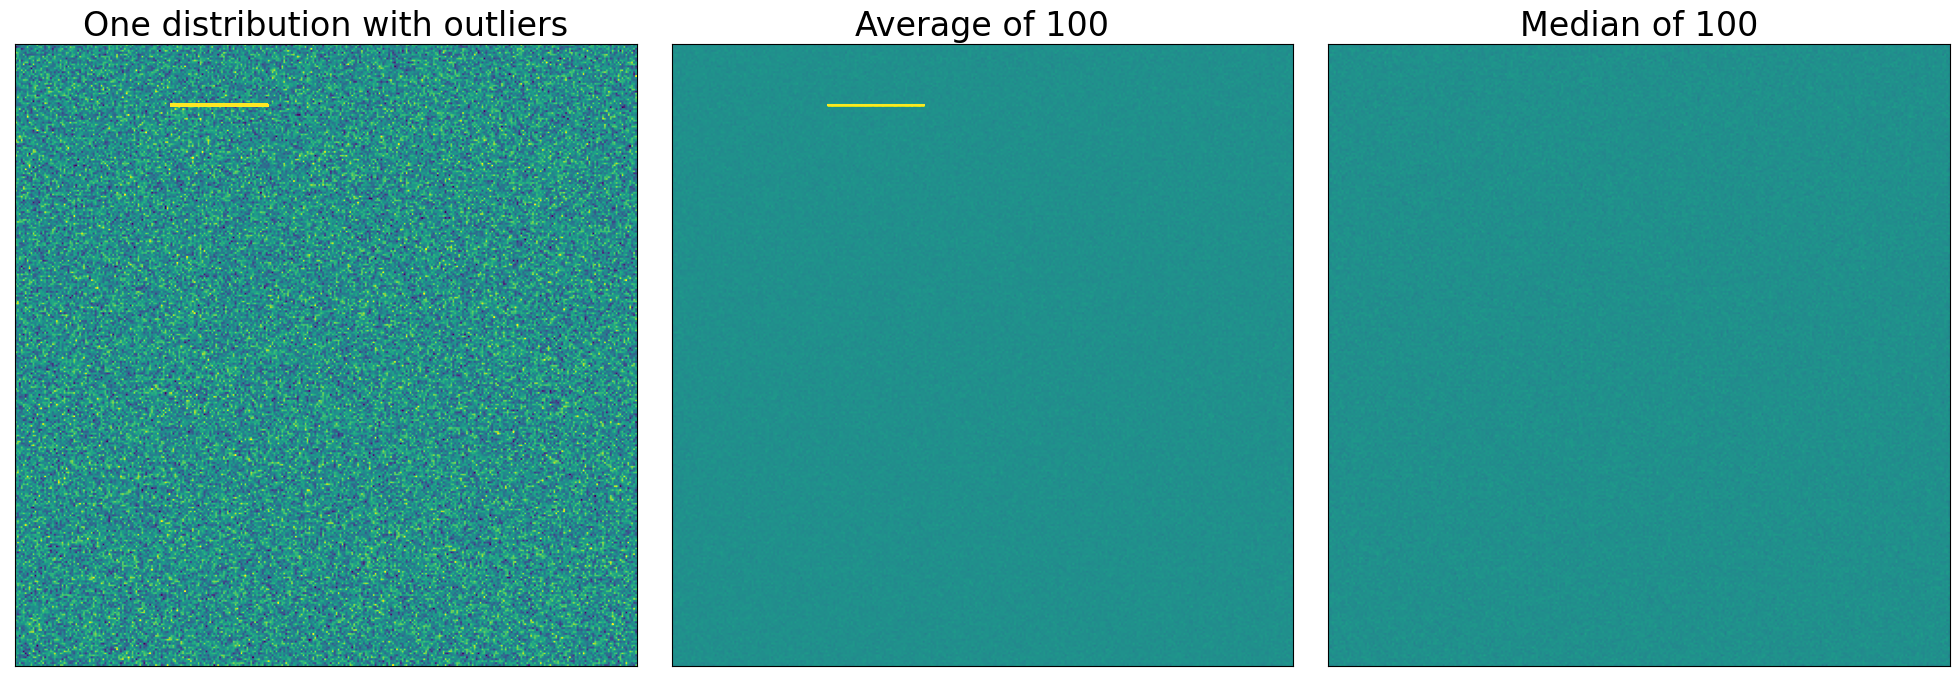

In [13]:
fig, axes = plt.subplots(1, 3, sharey=True, tight_layout=True, figsize=(20, 10))
data_source = [bits[0, :], average, median]
titles = ['One distribution with outliers', 'Average of {n}'.format(n=n_distributions), 'Median of {n}'.format(n=n_distributions)]

for axis, data, title in zip(axes, data_source, titles):
    axis.imshow(data.reshape(n_side, n_side), vmin=bias_level - 3, vmax=bias_level + 3)
    axis.set_xticks([])
    axis.set_yticks([])
    axis.grid(False)
    axis.set_title(title)

las imagenes astronomicas suelen tener esas caracteristicas transitorias

<h1>1.5.4. La solución: combinar promedio, pero recortar los valores extremos

<h4>No utilizar codigos a continuacion para reducir los ruidos, solo son para ver que es lo que hace la libreria ccdproc detras de escena

<h1>1.5.4.1. Recorte sigma 

esto recorta o elimina los valores que varian demaciado del valor tipico del pixel

en el siguiente ejemplo de ve porque usar solo el promedio y la desviacion estandar es una mala idea, ya que no se logran quitar los valores extremos cuando se combinan muy pocas imagenes

In [14]:
print('Number combined\t Average\t Standard dev σ \t 10σ ')

for n_to_combine in [10, 20, n_distributions]:
    avg = np.mean(bits[:n_to_combine, 10000])
    std = np.std(bits[:n_to_combine, 10000])
    print('{n:10d}\t{avg:10.2f}\t{std:10.2f}\t{ten_sig:10.2f}'.format(n=n_to_combine, 
                                         avg=avg, 
                                         std=std, ten_sig=10 * std))

Number combined	 Average	 Standard dev σ 	 10σ 
        10	   1100.03	    299.99	   2999.93
        20	   1050.03	    217.94	   2179.40
       100	   1009.92	     99.51	    995.11


se puede notar, que solo al combinar las 100 imagenes se logra quitar los valores extremos

Una mejor opción es usar la mediana como el valor típico y la desviación absoluta de la mediana en lugar de la desviación estándar como la medida de qué tan lejos está un valor del valor típico.

El ejemplo anterior pero con este nuevo metodo

In [15]:
print('{:^20}{:^20}{:^20}{:^20}'.format('Number combined', 'Median', 'MAD σ', '10σ'))

for n_to_combine in [10, 20, n_distributions]:
    avg = np.median(bits[:n_to_combine, 10000])
    std = mad_std(bits[:n_to_combine, 10000])
    print('{n:^20d}{avg:^20.2f}{std:^20.2f}{ten_sig:^20.2f}'.format(n=n_to_combine, 
                                         avg=avg, 
                                         std=std, ten_sig=10 * std))

  Number combined          Median              MAD σ                10σ         
         10               1000.33               0.97                9.68        
         20               1000.23               1.06               10.61        
        100                999.99               1.09               10.88        


La desventaja de este metodo es que es mucho mas costoso y lento para su ejecucion

In [16]:
mad_sigma = mad_std(bits, axis=0)

In [17]:
exclude = (bits - median) / mad_sigma > 10

In [18]:
original_values = bits[exclude]
bits[exclude] = np.nan

clip_combine = np.nanmean(bits, axis=0)
bits[exclude] = original_values

<h1>1.5.5. Resumen 

Text(0, 0.5, 'Number of pixels')

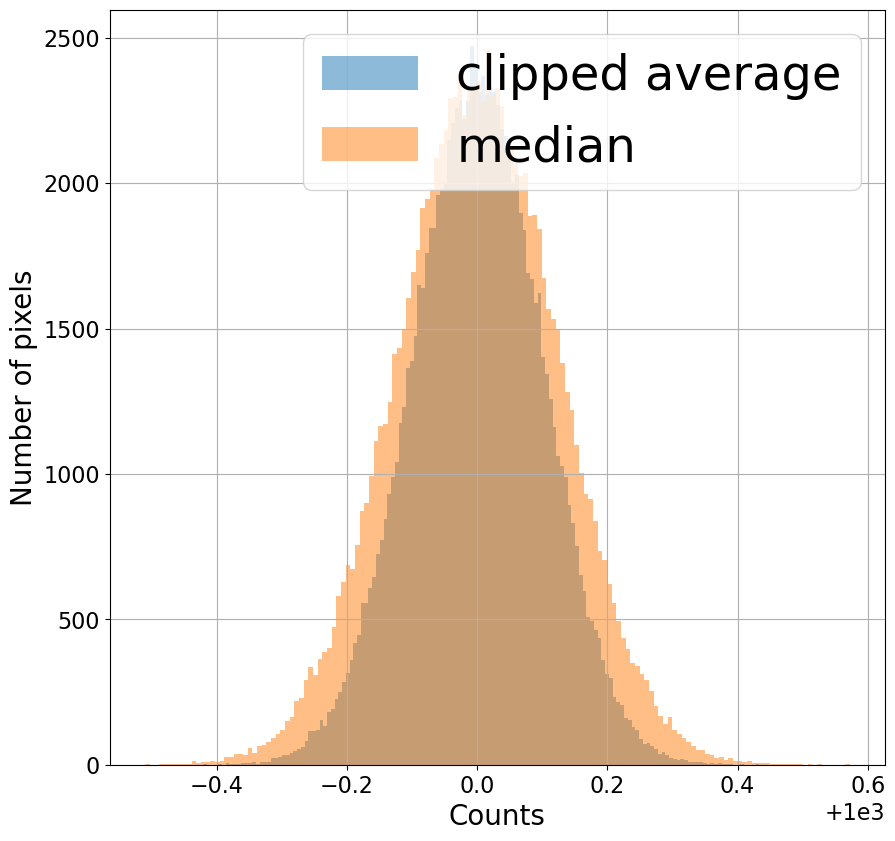

In [19]:
plt.figure(figsize=(10, 10))
hist(clip_combine, bins='freedman', alpha=0.5, label='clipped average')
hist(median, bins='freedman', alpha=0.5, label='median');
plt.legend()
plt.xlabel('Counts')
plt.ylabel('Number of pixels')